In [1]:
from miditoolkit.midi import parser as mid_parser  
from miditoolkit.midi import containers as ct
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema
from scipy.ndimage import gaussian_filter1d
import numpy as np
import os
from miditoolkit.pianoroll import parser as pr_parser
from miditoolkit.pianoroll import utils

In [44]:
def bar_filter(extracted):
    y_count=extracted.sum(axis=1)
    assert(len(y_count)==96)
    #filter bar: if max simotaneous note <=1
    if max(y_count)<=1:
        return True
    
    #filter bar: if total active duration <20% of a bar
    y_count=np.count_nonzero(y_count)
    if y_count/extracted.shape[0] <0.20:
        return True

    #otherwise: keep
    return False

    
def extract_44_bar(path):
    '''
    Input: path
    Return: ragged array, 
            each subarray(segment) in the return array represent continuous section in the score
                E.g.    Timesignature: 4/4 bar 1-10
                        Timesignature: 3/4 bar 11-12
                        Timesignature: 4/4 bar 13-15

                        Return:
                            [[bar1-10],[bar13-15]]
    ----------
    Remark: filtered bar will be represented by None
    '''
    pianoroll_time_dimension=24

    try:
        mido_obj=mid_parser.MidiFile(path)
    except Exception as e:
        print(f'GG: {e}',end=' ')
        return [],0
    
    tick_per_beat = mido_obj.ticks_per_beat
    time_signatures = mido_obj.time_signature_changes

    for ts in time_signatures:
        if ts.numerator==4 and ts.denominator==4:
            break
    else:
        return [],0

    #combine notes (checked: midi use absolute pitch)
    notes = [] 
    for instrument in mido_obj.instruments:
        if instrument.is_drum:
            continue
        for note in instrument.notes:
            notes.append(note)
    # notes.append(ct.Note(start=notes[0].start, end=notes[0].end, pitch=notes[0].pitch, velocity=notes[0].velocity))
    notes = sorted(notes,key=lambda note: note.start)

    #piano roll
    # REMARK: each note += 101 at corrsponding entry. 
    #         E.g. 808 means 8 identical notes (probably play by different instruments) at that entry

    factor_down = pianoroll_time_dimension/ tick_per_beat

    try:
        pianoroll = pr_parser.notes2pianoroll(
                            notes, 
                            ticks_per_beat=tick_per_beat,
                            resample_factor=factor_down,
                            binary_thres=1
                            )
        pianoroll = pianoroll[:, 24:108] #C1-C8
        pianoroll = pianoroll*1 #turn boolean to int
    except Exception as e:
        print(f'GG: {e}',end=' ')
        return [],0
    

    current_bar_start_at=0
    extracted_count=0
    segments=[]
    for idx,ts in enumerate(time_signatures):
        sel_bar=[]
        current_bar_length=ts.numerator*(4/ts.denominator)*tick_per_beat
        if idx!=len(time_signatures)-1:
            while current_bar_start_at<time_signatures[idx+1].time:
                if current_bar_start_at+current_bar_length<=time_signatures[idx+1].time:
                        if ts.numerator==4 and ts.denominator==4:
                            sel_bar.append(current_bar_start_at)
                current_bar_start_at+=current_bar_length
        else:
            while current_bar_start_at<notes[-1].end:
                if ts.numerator==4 and ts.denominator==4:
                    sel_bar.append(current_bar_start_at)
                current_bar_start_at+=current_bar_length

        if sel_bar!=[]:
            segment=[]
            for start_tick in sel_bar:
                extracted=pianoroll[int(start_tick*factor_down):int(start_tick*factor_down)+pianoroll_time_dimension*4]
                if extracted.shape[0]<pianoroll_time_dimension*4:
                    extracted=np.vstack((extracted,np.zeros((pianoroll_time_dimension*4-extracted.shape[0],84))))
                assert(len(extracted)==pianoroll_time_dimension*4)                
                if(bar_filter(extracted) == False):
                    segment.append(extracted)
                    extracted_count+=1
                else:
                    # dummy
                    segment.append(None)
            segments.append(segment)

    return segments,extracted_count


def paired_extract_44_bar(path):
    '''
    Input: path
    Return: ragged array of dictionary, 
            each subarray(segment) in the return array represent continuous section in the score
                E.g.    bar 1-10_piano, bar 1-10_orchestra (4/4)
                        bar 11-12_piano, bar 11-12_orchestra (3/4)
                        bar 13-20_piano, bar 13-20_orchestra (4/4)

                        Return:
                            [{'o':bar1-10_orchestra, 'p':bar1-10_piano},
                            {'o':bar13-15_orchestra, 'p':bar13-15_piano}]
    ----------
    Remark: filtered bar will be represented by None
    '''
    pianoroll_time_dimension=24

    try:
        mido_obj_o=mid_parser.MidiFile(path+'\orchestra.mid')
        mido_obj_p=mid_parser.MidiFile(path+'\piano.mid')
    except:
        print('GG',end=' ')
        return [],0
    
    tick_per_beat_o = mido_obj_o.ticks_per_beat
    tick_per_beat_p = mido_obj_p.ticks_per_beat
    time_signatures_o = mido_obj_o.time_signature_changes
    time_signatures_p = mido_obj_p.time_signature_changes
    
    #make sure they r identical in terms of metadata
    if not time_signatures_o==time_signatures_p or not tick_per_beat_o==tick_per_beat_p:
        return [],0
    
    # all no time signature
    #if len(time_signatures_o)!=0:
    #    print('~',end=' ')
    
    
    #assuming all are 4/4
    notes_o = [] 
    for instrument in mido_obj_o.instruments:
        if instrument.is_drum:
            continue
        for note in instrument.notes:
            notes_o.append(note)
    note_o = sorted(note_o,key=lambda note: note.start)
    notes_p = [] 
    for instrument in mido_obj_p.instruments:
        if instrument.is_drum:
            continue
        for note in instrument.notes:
            notes_p.append(note)
    note_p = sorted(note_p,key=lambda note: note.start)


    factor_down = pianoroll_time_dimension/ tick_per_beat_o

    try:
        pianoroll_o = pr_parser.notes2pianoroll(
                            notes_o, 
                            ticks_per_beat=tick_per_beat_o,
                            resample_factor=factor_down,
                            binary_thres=1)
        pianoroll_o = pianoroll_o[:, 24:108] #C1-C8
        pianoroll_o = pianoroll_o*1
        
        pianoroll_p = pr_parser.notes2pianoroll(
                            notes_p, 
                            ticks_per_beat=tick_per_beat_p,
                            resample_factor=factor_down,
                            binary_thres=1)
        pianoroll_p = pianoroll_p[:, 24:108] #C1-C8
        pianoroll_p = pianoroll_p*1

    except:
        print('GG',end=' ')
        return [],0
    

    current_bar_start_at=0
    extracted_count=0
    segments={'o':[],'p':[]}

    sel_bar=[]
    current_bar_length=(4)*tick_per_beat_o

    while current_bar_start_at<notes_o[-1].end:
        sel_bar.append(current_bar_start_at)
        current_bar_start_at+=current_bar_length

    if sel_bar!=[]:
        segment_o=[]
        segment_p=[]
        for start_tick in sel_bar:
            extracted_o=pianoroll_o[int(start_tick*factor_down):int(start_tick*factor_down)+pianoroll_time_dimension*4]
            extracted_p=pianoroll_p[int(start_tick*factor_down):int(start_tick*factor_down)+pianoroll_time_dimension*4]
            if extracted_o.shape[0]<pianoroll_time_dimension*4:
                extracted_o=np.vstack((extracted_o,np.zeros((pianoroll_time_dimension*4-extracted_o.shape[0],84))))
            if extracted_p.shape[0]<pianoroll_time_dimension*4:
                extracted_p=np.vstack((extracted_p,np.zeros((pianoroll_time_dimension*4-extracted_p.shape[0],84))))
            assert(len(extracted_o)==pianoroll_time_dimension*4 and len(extracted_p)==pianoroll_time_dimension*4)                
            #filter on orchestra
            if(bar_filter(extracted_o) == False):
                segment_o.append(extracted_o)
                segment_p.append(extracted_p)
                extracted_count+=1
            else:
                segment_o.append(None)
                segment_p.append(None)
        segments['o'].append(segment_o)
        segments['p'].append(segment_p)

    return segments,extracted_count

In [47]:
a,b = paired_extract_44_bar("orchestra.mid")
print(a)

[]


In [46]:
a = np.array(a)
print(a.shape)
a = a.reshape(1,a.shape[1]*a.shape[2],84)

(0,)


IndexError: tuple index out of range

In [49]:
import pypianoroll
import matplotlib.pyplot as plt
track = pypianoroll.read('orchestra.mid')
axs = track.plot()
plt.show()

KeyboardInterrupt: 

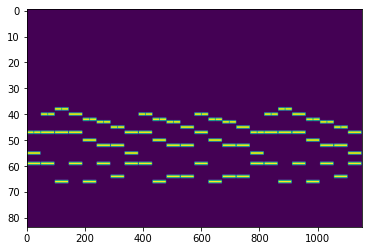

In [38]:
a = np.flip(a,2)
plt.imshow(a.T,aspect='auto')
plt.show()

In [3]:
def all_midi_file(root_path):
    root_path = os.walk(root_path)
    for root, directories, files in root_path:
        for file in files:
            if file.endswith('.mid'):
                yield root+'\\'+file

In [4]:
data_path='../data/'

In [5]:
piano=['PianoMidi_nicely_formatted','GiantMIDI_piano(messy)']
orchestra=['orchestra','Polyphonic_music_Bach','scena']
paired=['LOP_piano&Orchestra_RAW']

In [6]:
orchestra_data=[]
total_orchestra_bar=0
for o in orchestra:
    for file in all_midi_file(data_path+o):
        ans,count=extract_44_bar(file)
        if ans!=[]:
            total_orchestra_bar+=count
            orchestra_data.append(ans)

GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG GG 

In [7]:
total_orchestra_bar

38947

In [8]:
piano_data=[]
total_piano_bar=0
for p in piano:
    for file in all_midi_file(data_path+p):
        if total_piano_bar>total_orchestra_bar:
            break            
        ans,count=extract_44_bar(file)
        if ans!=[]:
            total_piano_bar+=count
            piano_data.append(ans)        

GG 

In [9]:
total_piano_bar

39313

In [10]:
total_orchestra_bar,total_piano_bar

(38947, 39313)

In [12]:
paired_data=[]
extracted_o_count=0
root_path = os.walk(data_path+paired[0])
for root, directories, files in root_path:
    for d in directories:
        segments,count=paired_extract_44_bar(root+'/'+d)
        if segments!=[]:
            extracted_o_count+=count
            paired_data.append(segments)   
extracted_o_count

20203

In [14]:
import pickle


with open('paired.pickle', 'wb') as pair:
    pickle.dump(paired_data, pair, protocol=pickle.HIGHEST_PROTOCOL)

with open('orchestra.pickle', 'wb') as o:
    pickle.dump(orchestra_data, o, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('piano.pickle', 'wb') as p:
    pickle.dump(piano_data, p, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
tc_gt_1_o=0
tc_gt_1_p=0
tc_st_1_o=0
tc_st_1_p=0
tc_eq_44_o=0
tc_eq_44_p=0

ts={'a':0}

for o in orchestra:
    for file in all_midi_file(data_path+o):
        try:
            mido_obj = mid_parser.MidiFile(file)
        except:
            print('error:',file)
            continue
        tc=mido_obj.time_signature_changes
        for t in tc:
            temp=str(t.numerator)+'/'+str(t.denominator)
            if temp in ts:
                ts[temp]+=1
            else:
                ts[temp]=1

error: ../data/orchestra\Holst\jupiter.mid
error: ../data/orchestra\Lemire\alsace.mid
error: ../data/orchestra\Lemire\claudtte.mid
error: ../data/orchestra\Lemire\colmar.mid
error: ../data/orchestra\Lemire\coloniau.mid
error: ../data/orchestra\Lemire\defile.mid
error: ../data/orchestra\Lemire\emirel.mid
error: ../data/orchestra\Lemire\filondor.mid
error: ../data/orchestra\Lemire\hommage.mid
error: ../data/orchestra\Lemire\marcheam.mid
error: ../data/orchestra\Lemire\moreznne.mid
error: ../data/orchestra\Lemire\ouvertur.mid
error: ../data/orchestra\Lemire\paulette.mid
error: ../data/orchestra\Lemire\ranali.mid
error: ../data/orchestra\Lemire\viecolon.mid
error: ../data/orchestra\Mascagni\intermez.mid
error: ../data/orchestra\Moussorgsky\promenad.mid
error: ../data/orchestra\Orff\ofortuna.mid
error: ../data/orchestra\Puccini\humming.mid
error: ../data/orchestra\Puccini\unbeldi.mid
error: ../data/orchestra\Verdi\celeste.mid
error: ../data/orchestra\Verdi\numi.mid
error: ../data/orchestra\

In [ ]:
ts